<a name="top"></a>
# **HW15 Meta Learning: Few-shot Classification**

This is the sample code for homework 15.

Please mail to mlta-2023-spring@googlegroups.com if you have any questions.

## **Step 0: Check GPU**

In [ ]:
#HW_15_LHE_ML R11945072 Bo-Yen Chang

In [ ]:
!nvidia-smi

Fri Jun 30 12:51:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Step 1: Download Data**

Run the cell to download data, which has been pre-processed by TAs.  
The dataset has been augmented, so extra data augmentation is not required.


In [ ]:
workspace_dir = '.'

# Download dataset
!wget https://www.dropbox.com/s/pqeym3n4jly5e89/Omniglot.tar.gz?dl=1 \
    -O "{workspace_dir}/Omniglot.tar.gz"
!wget https://www.dropbox.com/s/nlvokertmksfc42/Omniglot-test.tar.gz?dl=1 \
    -O "{workspace_dir}/Omniglot-test.tar.gz"

# Use `tar' command to decompress
!tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"
!tar -zxf "{workspace_dir}/Omniglot-test.tar.gz" -C "{workspace_dir}/"

--2023-06-30 12:51:56--  https://www.dropbox.com/s/pqeym3n4jly5e89/Omniglot.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/pqeym3n4jly5e89/Omniglot.tar.gz [following]
--2023-06-30 12:51:56--  https://www.dropbox.com/s/dl/pqeym3n4jly5e89/Omniglot.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3c27626ab0bdcac3cbaef9b94b.dl.dropboxusercontent.com/cd/0/get/B--RUvtQa5QFO463FyvY2R6VYTc9HK41zhUwrLJH6TqxjeY1JsBSLf_zfZ8bz94AMLVqRHkvOqTienOaXssnKoVaZU_1bsYNunZKCMBXd7T9eEYFAcTOVSVCWd4FckyVh52Q7UDjmuQulKX2VnhjiIKw8qkq0i8QvhVpkNie_5QzlQSZhRBEwSreex080j23mi8/file?dl=1# [following]
--2023-06-30 12:51:56--  https://uc3c27626ab0bdcac3cbaef9b94b.dl.dropboxusercontent.com/cd/0/get/B--RUvtQa5QFO463FyvY2R6VYTc9HK41zhUwrLJH6TqxjeY1

## **Step 2: Build the model**

### Library importation

In [ ]:
# Import modules we need
import glob, random
from collections import OrderedDict

import numpy as np
from tqdm.auto import tqdm

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE = {device}")

# Fix random seeds
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

DEVICE = cuda


### Model Construction Preliminaries

Since our task is image classification, we need to build a CNN-based model.  
However, to implement MAML algorithm, we should adjust some code in `nn.Module`.


Take a look at MAML pseudocode...

<img src="https://i.imgur.com/9aHlvfX.png" width="50%" />

On the 10-th line, what we take gradients on are those $\theta$ representing  
<font color="#0CC">**the original model parameters**</font> (outer loop) instead of those in  the  
<font color="#0C0">**inner loop**</font>, so we need to use `functional_forward` to compute the output  
logits of input image instead of `forward` in `nn.Module`.

The following defines these functions.

<!-- 由於在第10行，我們是要對原本的參數 θ 微分，並非 inner-loop (Line5~8) 的 θ' 微分，因此在 inner-loop，我們需要用 functional forward 的方式算出 input image 的 output logits，而不是直接用 nn.module 裡面的 forward（直接對 θ 微分）。在下面我們分別定義了 functional forward 以及 forward 函數。 -->

### Model block definition

In [ ]:
def ConvBlock(in_ch: int, out_ch: int):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )


def ConvBlockFunction(x, w, b, w_bn, b_bn):
    x = F.conv2d(x, w, b, padding=1)
    x = F.batch_norm(
        x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True
    )
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    return x

### Model definition

In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_ch, k_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, k_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)
        return x

    def functional_forward(self, x, params):
        """
        Arguments:
        x: input images [batch, 1, 28, 28]
        params: model parameters,
                i.e. weights and biases of convolution
                     and weights and biases of
                                   batch normalization
                type is an OrderedDict

        Arguments:
        x: input images [batch, 1, 28, 28]
        params: The model parameters,
                i.e. weights and biases of convolution
                     and batch normalization layers
                It's an `OrderedDict`
        """
        for block in [1, 2, 3, 4]:
            x = ConvBlockFunction(
                x,
                params[f"conv{block}.0.weight"],
                params[f"conv{block}.0.bias"],
                params.get(f"conv{block}.1.weight"),
                params.get(f"conv{block}.1.bias"),
            )
        x = x.view(x.shape[0], -1)
        x = F.linear(x, params["logits.weight"], params["logits.bias"])
        return x

### Create Label

This function is used to create labels.  
In a N-way K-shot few-shot classification problem,
each task has `n_way` classes, while there are `k_shot` images for each class.  
This is a function that creates such labels.


In [ ]:
def create_label(n_way, k_shot):
    return torch.arange(n_way).repeat_interleave(k_shot).long()


# Try to create labels for 5-way 2-shot setting
create_label(5, 2)

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

### Accuracy calculation

In [ ]:
def calculate_accuracy(logits, labels):
    """utility function for accuracy calculation"""
    acc = np.asarray(
        [(torch.argmax(logits, -1).cpu().numpy() == labels.cpu().numpy())]
    ).mean()
    return acc

### Define Dataset

Define the dataset.  
The dataset returns images of a random character, with (`k_shot + q_query`) images,  
so the size of returned tensor is `[k_shot+q_query, 1, 28, 28]`.  


In [ ]:
# Dataset for train and val
class Omniglot(Dataset):
    def __init__(self, data_dir, k_shot, q_query, task_num=None):####
        self.file_list = [
            f for f in glob.glob(data_dir + "**/character*", recursive=True)
        ]
        # limit task number if task_num is set
        if task_num is not None:
            self.file_list = self.file_list[: min(len(self.file_list), task_num)]
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.n = k_shot + q_query

    def __getitem__(self, idx):
        # For random sampling the characters we want.
        #img_path = self.file_list[idx]
        #img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
        #img_list.sort()

        #sample = np.arange(len(img_list))
        #np.random.shuffle(sample)

        # `k_shot + q_query` examples for each character
        #imgs = [self.transform(Image.open(img_list[idx])) for idx in sample[:self.n]]
        #imgs = torch.stack(imgs)

        sample = np.arange(20)

        # For random sampling the characters we want.
        np.random.shuffle(sample)
        img_path = self.file_list[idx]
        img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
        img_list.sort()
        imgs = [self.transform(Image.open(img_file)) for img_file in img_list]
        # `k_way + q_query` examples for each character
        imgs = torch.stack(imgs)[sample[: self.n]]
        return imgs


    def __len__(self):
        return len(self.file_list)

## **Step 3: Learning Algorithms**

### Transfer learning

The solver first chose five task from the training set, then do normal classification training on the chosen five tasks. In inference, the model finetune for `inner_train_step` steps on the support set images, and than do inference on the query set images.

For consistant with the meta-learning solver, the base solver has the exactly same input and output format with the meta-learning solver.



In [ ]:
def BaseSolver(
    model,
    optimizer,
    x,
    n_way,
    k_shot,
    q_query,
    loss_fn,
    inner_train_step=1,
    inner_lr=0.4,
    train=True,
    return_labels=False,
):
    criterion, task_loss, task_acc = loss_fn, [], []
    labels = []

    for meta_batch in x:
        # Get data
        support_set = meta_batch[: n_way * k_shot]
        query_set = meta_batch[n_way * k_shot :]

        if train:
            """ training loop """
            # Use the support set to calculate loss
            labels = create_label(n_way, k_shot).to(device)
            logits = model.forward(support_set)
            loss = criterion(logits, labels)

            task_loss.append(loss)
            task_acc.append(calculate_accuracy(logits, labels))
        else:
            """ validation / testing loop """
            # First update model with support set images for `inner_train_step` steps
            fast_weights = OrderedDict(model.named_parameters())


            for inner_step in range(inner_train_step):
                # Simply training
                train_label = create_label(n_way, k_shot).to(device)
                logits = model.functional_forward(support_set, fast_weights)
                loss = criterion(logits, train_label)

                grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)
                # Perform SGD
                fast_weights = OrderedDict(
                    (name, param - inner_lr * grad)
                    for ((name, param), grad) in zip(fast_weights.items(), grads)
                )

            if not return_labels:
                """ validation """
                val_label = create_label(n_way, q_query).to(device)

                logits = model.functional_forward(query_set, fast_weights)
                loss = criterion(logits, val_label)
                task_loss.append(loss)
                task_acc.append(calculate_accuracy(logits, val_label))
            else:
                """ testing """
                logits = model.functional_forward(query_set, fast_weights)
                labels.extend(torch.argmax(logits, -1).cpu().numpy())

    if return_labels:
        return labels

    batch_loss = torch.stack(task_loss).mean()
    task_acc = np.mean(task_acc)

    if train:
        # Update model
        model.train()
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    return batch_loss, task_acc

### Meta Learning

Here is the main Meta Learning algorithm.

Please finish the TODO blocks for the inner and outer loop update rules.

- For implementing FO-MAML you can refer to [p.25 of the slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf#page=25&view=FitW).

- For the original MAML, you can refer to [the slides of meta learning (p.13 ~ p.18)](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf#page=13&view=FitW).


In [ ]:
def MetaSolver(
    model,
    optimizer,
    x,
    n_way,
    k_shot,
    q_query,
    loss_fn,
    inner_train_step=1,
    inner_lr=0.4,
    train=True,
    return_labels=False
):
    criterion, task_loss, task_acc = loss_fn, [], []
    labels = []

    for meta_batch in x:
        # Get data
        if torch.rand(1).item() > 0.6:
            times = 1 if torch.rand(1).item() > 0.5 else 3
            meta_batch = torch.rot90(meta_batch, times, [-1, -2])
            ##
        support_set = meta_batch[: n_way * k_shot]
        query_set = meta_batch[n_way * k_shot :]

        # Copy the params for inner loop
        fast_weights = OrderedDict(model.named_parameters())

        ### ---------- INNER TRAIN LOOP ---------- ###
        for inner_step in range(inner_train_step):
            # Simply training
            train_label = create_label(n_way, k_shot).to(device)
            logits = model.functional_forward(support_set, fast_weights)
            loss = criterion(logits, train_label)
            # Inner gradients update! vvvvvvvvvvvvvvvvvvvv #
            """ Inner Loop Update """
            # TODO: Finish the inner loop update rule
            grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)
            fast_weights = OrderedDict((name, param - inner_lr * grad)
                for ((name, param), grad) in zip(fast_weights.items(), grads)
            )
    # Compute gradients only for the last layer
            #grads = torch.autograd.grad(loss, model.last_layer.parameters(), create_graph=True)

    # Get the name of the last layer
            #last_layer_name = list(fast_weights.keys())[-1]

    # Update the fast weights of the last layer only
            #fast_weights[last_layer_name] = fast_weights[last_layer_name] - inner_lr * grads[0]
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ #

        ### ---------- INNER VALID LOOP ---------- ###
        if not return_labels:
            """ training / validation """
            val_label = create_label(n_way, q_query).to(device)

            # Collect gradients for outer loop
            logits = model.functional_forward(query_set, fast_weights)
            loss = criterion(logits, val_label)
            task_loss.append(loss)
            task_acc.append(calculate_accuracy(logits, val_label))
        else:
            """ testing """
            logits = model.functional_forward(query_set, fast_weights)
            labels.extend(torch.argmax(logits, -1).cpu().numpy())

    if return_labels:
        return labels

    # Update outer loop
    model.train()
    optimizer.zero_grad()

    meta_batch_loss = torch.stack(task_loss).mean()
    if train:
        """ Outer Loop Update """
        # TODO: Finish the outer loop update
        meta_batch_loss.backward()
        optimizer.step()

    task_acc = np.mean(task_acc)
    return meta_batch_loss, task_acc

## **Step 4: Initialization**

After defining all components we need, the following initialize a model before training.

### Hyperparameters

In [ ]:
n_way = 5
k_shot = 1
q_query = 1
train_inner_train_step = 1
val_inner_train_step = 3
inner_lr = 0.4
meta_lr = 0.001
meta_batch_size = 32
max_epoch = 160
eval_batches = 20
train_data_path = "./Omniglot/images_background/"

### Dataloader initialization

In [ ]:
def dataloader_init(datasets, shuffle=True, num_workers=2):
    train_set, val_set = datasets
    train_loader = DataLoader(
        train_set,
        # The "batch_size" here is not \
        #    the meta batch size, but  \
        #    how many different        \
        #    characters in a task,     \
        #    i.e. the "n_way" in       \
        #    few-shot classification.
        batch_size=n_way,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_set, batch_size=n_way, num_workers=num_workers, shuffle=shuffle, drop_last=True
    )

    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    return (train_loader, val_loader), (train_iter, val_iter)

### Model & optimizer initialization

In [ ]:
def model_init():
    meta_model = Classifier(1, n_way).to(device)
    optimizer = torch.optim.Adam(meta_model.parameters(), lr=meta_lr)
    loss_fn = nn.CrossEntropyLoss().to(device)
    return meta_model, optimizer, loss_fn

### Utility function to get a meta-batch

In [ ]:
def get_meta_batch(meta_batch_size, k_shot, q_query, data_loader, iterator):
    data = []
    for _ in range(meta_batch_size):
        try:
            # a "task_data" tensor is representing \
            #     the data of a task, with size of \
            #     [n_way, k_shot+q_query, 1, 28, 28]
            task_data = next(iterator)
        except StopIteration:
            iterator = iter(data_loader)
            task_data = next(iterator)
        train_data = task_data[:, :k_shot].reshape(-1, 1, 28, 28)
        val_data = task_data[:, k_shot:].reshape(-1, 1, 28, 28)
        task_data = torch.cat((train_data, val_data), 0)
        data.append(task_data)
    return torch.stack(data).to(device), iterator


<a name="mainprog" id="mainprog"></a>
## **Step 5: Main program for training & testing**

### Start training!
With `solver = 'base'`, the solver is a transfer learning algorithm.

Once you finish the TODO blocks in the `MetaSolver`, change the variable `solver = 'meta'` to start training with meta learning algorithm.


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

class RepeatDataset(Dataset):
    def __init__(self, dataset, repeats):
        self.dataset = dataset
        self.repeats = repeats

    def __len__(self):
        return len(self.dataset) * self.repeats

    def __getitem__(self, idx):
        return self.dataset[idx % len(self.dataset)]

task_nums = [5, 10, 20]
dev_accs = {}

for task_num in task_nums: # start of the loop for different numbers of tasks

    solver = 'meta' # base, meta
    meta_model, optimizer, loss_fn = model_init()

    # init solver and dataset according to solver type
    if solver == 'base':
        max_epoch = 5 # the base solver only needs 5 epochs
        Solver = BaseSolver
        train_set, val_set = torch.utils.data.random_split(
            Omniglot(train_data_path, k_shot, q_query, task_num=task_num), [5, 5]
        )
        (train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set), shuffle=False)

    elif solver == 'meta':
        Solver = MetaSolver
        dataset = Omniglot(train_data_path, k_shot, q_query, task_num=task_num) # use task_num here

        # Repeat your dataset
        repeats = 100  # Repeat 100 times, you can adjust this value freely
        repeated_dataset = RepeatDataset(dataset, repeats=repeats)

        train_split = int(0.8 * len(repeated_dataset))
        val_split = len(repeated_dataset) - train_split
        train_set, val_set = torch.utils.data.random_split(
            repeated_dataset, [train_split, val_split]
        )

        # Initialize DataLoader
        # Initialize DataLoader
        # Initialize DataLoader
        batch_size = 5  # Adjust to match target batch size
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize iterator
        train_iter = iter(train_loader)
        val_iter = iter(val_loader)


    else:
        raise NotImplementedError

    # main training loop
    train_iter = iter(train_loader)
    for epoch in range(max_epoch):
        print("Epoch %d" % (epoch + 1))
        train_meta_loss = []
        train_acc = []
        # The "step" here is a meta-gradinet update step
        for step in tqdm(range(max(1, len(train_loader) // meta_batch_size))):
            x, train_iter = get_meta_batch(
                meta_batch_size, k_shot, q_query, train_loader, train_iter
            )
            meta_loss, acc = Solver(
                meta_model,
                optimizer,
                x,
                n_way,
                k_shot,
                q_query,
                loss_fn,
                inner_train_step=train_inner_train_step
            )
            train_meta_loss.append(meta_loss.item())
            train_acc.append(acc)
        print("  Loss    : ", "%.3f" % (np.mean(train_meta_loss)), end="\t")
        print("  Accuracy: ", "%.3f %%" % (np.mean(train_acc) * 100))

        # See the validation accuracy after each epoch.
        # Early stopping is welcomed to implement.
        val_acc = []
        for eval_step in tqdm(range(max(1, len(val_loader) // (eval_batches)))):
            x, val_iter = get_meta_batch(
                eval_batches, k_shot, q_query, val_loader, val_iter
            )
            # We update three inner steps when testing.
            _, acc = Solver(
                meta_model,
                optimizer,
                x,
                n_way,
                k_shot,
                q_query,
                loss_fn,
                inner_train_step=val_inner_train_step,
                train=False,
            )
            val_acc.append(acc)
        print("  Validation accuracy: ", "%.3f %%" % (np.mean(val_acc) * 100))

    final_dev_accuracy = np.mean(val_acc) * 100
    # Store the final dev accuracy in the dictionary with the corresponding task number
    dev_accs[task_num] = final_dev_accuracy



Epoch 1


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  3.557	  Accuracy:  20.000 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  27.000 %
Epoch 2


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  2.184	  Accuracy:  27.187 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  39.000 %
Epoch 3


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.563	  Accuracy:  34.375 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  37.000 %
Epoch 4


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.497	  Accuracy:  36.562 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  32.000 %
Epoch 5


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.403	  Accuracy:  36.875 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  34.000 %
Epoch 6


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.363	  Accuracy:  43.750 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  33.000 %
Epoch 7


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.379	  Accuracy:  36.875 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  34.000 %
Epoch 8


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.330	  Accuracy:  44.688 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  39.000 %
Epoch 9


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.263	  Accuracy:  49.375 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  35.000 %
Epoch 10


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.280	  Accuracy:  50.625 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  40.000 %
Epoch 11


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.312	  Accuracy:  47.500 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  42.000 %
Epoch 12


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.278	  Accuracy:  45.625 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  40.000 %
Epoch 13


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.259	  Accuracy:  46.562 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  41.000 %
Epoch 14


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.232	  Accuracy:  48.750 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  38.000 %
Epoch 15


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.230	  Accuracy:  48.438 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  42.000 %
Epoch 16


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.250	  Accuracy:  48.750 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  42.000 %
Epoch 17


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.229	  Accuracy:  49.688 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  38.000 %
Epoch 18


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.229	  Accuracy:  49.375 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  38.000 %
Epoch 19


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.239	  Accuracy:  48.125 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  46.000 %
Epoch 20


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.197	  Accuracy:  49.688 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  37.000 %
Epoch 21


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.192	  Accuracy:  49.375 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  49.000 %
Epoch 22


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.178	  Accuracy:  46.250 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  42.000 %
Epoch 23


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.148	  Accuracy:  48.125 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  44.000 %
Epoch 24


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.089	  Accuracy:  57.500 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  41.000 %
Epoch 25


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.111	  Accuracy:  49.062 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  48.000 %
Epoch 26


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.127	  Accuracy:  47.500 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  42.000 %
Epoch 27


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.118	  Accuracy:  53.437 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  43.000 %
Epoch 28


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.066	  Accuracy:  54.375 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  46.000 %
Epoch 29


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.083	  Accuracy:  49.375 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  44.000 %
Epoch 30


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.041	  Accuracy:  55.625 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  38.000 %
Epoch 31


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.052	  Accuracy:  55.937 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  43.000 %
Epoch 32


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.081	  Accuracy:  51.562 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  45.000 %
Epoch 33


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.010	  Accuracy:  54.062 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  44.000 %
Epoch 34


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.993	  Accuracy:  58.125 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  46.000 %
Epoch 35


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.027	  Accuracy:  53.438 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  51.000 %
Epoch 36


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.005	  Accuracy:  55.000 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  53.000 %
Epoch 37


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.984	  Accuracy:  54.062 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  46.000 %
Epoch 38


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.983	  Accuracy:  54.688 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  47.000 %
Epoch 39


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.976	  Accuracy:  58.438 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  45.000 %
Epoch 40


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.930	  Accuracy:  59.062 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  54.000 %
Epoch 41


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.889	  Accuracy:  60.625 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  46.000 %
Epoch 42


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  1.004	  Accuracy:  54.062 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  48.000 %
Epoch 43


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.891	  Accuracy:  57.188 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  49.000 %
Epoch 44


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.819	  Accuracy:  65.312 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  52.000 %
Epoch 45


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.877	  Accuracy:  62.813 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  45.000 %
Epoch 46


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.906	  Accuracy:  59.688 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  54.000 %
Epoch 47


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.922	  Accuracy:  57.500 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  41.000 %
Epoch 48


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.849	  Accuracy:  61.562 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  49.000 %
Epoch 49


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.871	  Accuracy:  61.250 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  48.000 %
Epoch 50


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.847	  Accuracy:  57.812 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  45.000 %
Epoch 51


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.854	  Accuracy:  60.625 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  45.000 %
Epoch 52


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.828	  Accuracy:  63.750 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  45.000 %
Epoch 53


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.824	  Accuracy:  62.500 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  48.000 %
Epoch 54


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.820	  Accuracy:  59.688 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  52.000 %
Epoch 55


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.793	  Accuracy:  62.188 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  53.000 %
Epoch 56


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.814	  Accuracy:  61.875 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  56.000 %
Epoch 57


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.850	  Accuracy:  57.500 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  52.000 %
Epoch 58


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.753	  Accuracy:  66.875 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  53.000 %
Epoch 59


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.801	  Accuracy:  61.562 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  54.000 %
Epoch 60


  0%|          | 0/2 [00:00<?, ?it/s]

  Loss    :  0.765	  Accuracy:  66.250 %


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation accuracy:  53.000 %
Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  2.969	  Accuracy:  26.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  37.500 %
Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.401	  Accuracy:  44.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  47.500 %
Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.327	  Accuracy:  45.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  50.000 %
Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.271	  Accuracy:  51.500 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  51.000 %
Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.233	  Accuracy:  52.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  48.000 %
Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.181	  Accuracy:  59.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  54.000 %
Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.108	  Accuracy:  58.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  51.000 %
Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.107	  Accuracy:  58.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  61.500 %
Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.029	  Accuracy:  57.500 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  53.500 %
Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  1.015	  Accuracy:  61.625 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  60.500 %
Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.973	  Accuracy:  61.625 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  60.000 %
Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.883	  Accuracy:  66.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  60.500 %
Epoch 13


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.873	  Accuracy:  64.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  60.500 %
Epoch 14


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.795	  Accuracy:  69.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  59.000 %
Epoch 15


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.790	  Accuracy:  69.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  63.500 %
Epoch 16


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.758	  Accuracy:  69.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  58.000 %
Epoch 17


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.742	  Accuracy:  70.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  61.000 %
Epoch 18


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.723	  Accuracy:  71.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  64.500 %
Epoch 19


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.700	  Accuracy:  72.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  59.000 %
Epoch 20


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.671	  Accuracy:  73.250 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  65.500 %
Epoch 21


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.667	  Accuracy:  72.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  64.500 %
Epoch 22


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.674	  Accuracy:  71.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  62.500 %
Epoch 23


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.627	  Accuracy:  74.625 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  66.500 %
Epoch 24


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.622	  Accuracy:  73.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  64.500 %
Epoch 25


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.599	  Accuracy:  74.500 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  72.000 %
Epoch 26


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.572	  Accuracy:  75.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.000 %
Epoch 27


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.560	  Accuracy:  75.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  76.000 %
Epoch 28


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.569	  Accuracy:  76.500 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.000 %
Epoch 29


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.517	  Accuracy:  79.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  72.000 %
Epoch 30


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.558	  Accuracy:  74.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  72.000 %
Epoch 31


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.517	  Accuracy:  76.625 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  72.000 %
Epoch 32


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.527	  Accuracy:  76.250 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  76.500 %
Epoch 33


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.506	  Accuracy:  78.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.000 %
Epoch 34


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.499	  Accuracy:  77.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  68.500 %
Epoch 35


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.487	  Accuracy:  76.625 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  70.000 %
Epoch 36


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.469	  Accuracy:  80.625 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  72.500 %
Epoch 37


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.474	  Accuracy:  77.750 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  71.500 %
Epoch 38


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.478	  Accuracy:  78.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  68.000 %
Epoch 39


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.482	  Accuracy:  78.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.000 %
Epoch 40


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.410	  Accuracy:  82.125 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  74.000 %
Epoch 41


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.435	  Accuracy:  79.750 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  77.000 %
Epoch 42


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.490	  Accuracy:  75.500 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  75.500 %
Epoch 43


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.439	  Accuracy:  78.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  72.000 %
Epoch 44


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.433	  Accuracy:  80.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  69.500 %
Epoch 45


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.428	  Accuracy:  79.625 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  69.000 %
Epoch 46


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.464	  Accuracy:  77.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  70.000 %
Epoch 47


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.397	  Accuracy:  79.750 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.500 %
Epoch 48


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.416	  Accuracy:  79.750 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  78.000 %
Epoch 49


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.425	  Accuracy:  79.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  69.500 %
Epoch 50


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.408	  Accuracy:  79.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  71.000 %
Epoch 51


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.420	  Accuracy:  78.250 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.000 %
Epoch 52


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.361	  Accuracy:  82.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.000 %
Epoch 53


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.428	  Accuracy:  78.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  75.500 %
Epoch 54


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.429	  Accuracy:  78.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  70.500 %
Epoch 55


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.391	  Accuracy:  80.750 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  79.000 %
Epoch 56


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.411	  Accuracy:  79.375 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  79.000 %
Epoch 57


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.403	  Accuracy:  79.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  77.500 %
Epoch 58


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.362	  Accuracy:  82.500 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  72.000 %
Epoch 59


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.386	  Accuracy:  80.875 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  78.000 %
Epoch 60


  0%|          | 0/5 [00:00<?, ?it/s]

  Loss    :  0.377	  Accuracy:  81.000 %


  0%|          | 0/2 [00:00<?, ?it/s]

  Validation accuracy:  73.000 %
Epoch 1


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  1.796	  Accuracy:  38.750 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  43.500 %
Epoch 2


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  1.152	  Accuracy:  55.937 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  48.500 %
Epoch 3


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  1.089	  Accuracy:  61.562 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  54.500 %
Epoch 4


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.981	  Accuracy:  64.000 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  55.500 %
Epoch 5


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.874	  Accuracy:  67.938 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  63.500 %
Epoch 6


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.789	  Accuracy:  70.813 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  61.000 %
Epoch 7


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.750	  Accuracy:  70.813 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  63.750 %
Epoch 8


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.687	  Accuracy:  74.312 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  66.000 %
Epoch 9


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.621	  Accuracy:  77.062 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  72.500 %
Epoch 10


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.575	  Accuracy:  79.313 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  71.500 %
Epoch 11


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.547	  Accuracy:  79.750 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  75.750 %
Epoch 12


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.514	  Accuracy:  80.625 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  75.500 %
Epoch 13


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.518	  Accuracy:  80.750 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  73.250 %
Epoch 14


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.451	  Accuracy:  83.125 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  83.000 %
Epoch 15


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.455	  Accuracy:  83.000 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  77.000 %
Epoch 16


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.435	  Accuracy:  83.750 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  79.250 %
Epoch 17


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.420	  Accuracy:  83.875 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  74.250 %
Epoch 18


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.406	  Accuracy:  84.438 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  82.250 %
Epoch 19


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.398	  Accuracy:  85.000 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  83.750 %
Epoch 20


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.375	  Accuracy:  85.437 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  86.500 %
Epoch 21


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.370	  Accuracy:  85.688 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  83.000 %
Epoch 22


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.366	  Accuracy:  85.375 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  85.000 %
Epoch 23


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.346	  Accuracy:  87.063 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  81.750 %
Epoch 24


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.359	  Accuracy:  85.000 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.500 %
Epoch 25


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.353	  Accuracy:  86.625 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  89.000 %
Epoch 26


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.350	  Accuracy:  86.125 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  80.500 %
Epoch 27


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.361	  Accuracy:  85.750 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  82.250 %
Epoch 28


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.329	  Accuracy:  87.438 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  84.250 %
Epoch 29


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.321	  Accuracy:  87.375 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  84.000 %
Epoch 30


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.329	  Accuracy:  86.938 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  85.000 %
Epoch 31


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.305	  Accuracy:  86.750 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  85.000 %
Epoch 32


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.326	  Accuracy:  85.625 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  85.500 %
Epoch 33


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.320	  Accuracy:  86.375 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  88.750 %
Epoch 34


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.319	  Accuracy:  86.438 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  88.000 %
Epoch 35


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.323	  Accuracy:  86.812 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  84.750 %
Epoch 36


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.292	  Accuracy:  88.438 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  89.750 %
Epoch 37


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.282	  Accuracy:  88.625 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.250 %
Epoch 38


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.274	  Accuracy:  88.375 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.750 %
Epoch 39


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.300	  Accuracy:  87.188 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.250 %
Epoch 40


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.299	  Accuracy:  87.375 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  86.500 %
Epoch 41


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.272	  Accuracy:  88.125 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  84.250 %
Epoch 42


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.295	  Accuracy:  87.688 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  88.500 %
Epoch 43


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.265	  Accuracy:  88.875 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  90.000 %
Epoch 44


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.256	  Accuracy:  89.688 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  84.750 %
Epoch 45


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.270	  Accuracy:  88.812 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.250 %
Epoch 46


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.279	  Accuracy:  88.125 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  84.750 %
Epoch 47


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.286	  Accuracy:  86.688 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  83.750 %
Epoch 48


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.260	  Accuracy:  88.188 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  89.000 %
Epoch 49


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.262	  Accuracy:  88.625 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  88.000 %
Epoch 50


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.245	  Accuracy:  89.625 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  86.000 %
Epoch 51


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.250	  Accuracy:  89.625 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  88.000 %
Epoch 52


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.255	  Accuracy:  89.375 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  84.500 %
Epoch 53


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.251	  Accuracy:  88.250 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  88.000 %
Epoch 54


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.257	  Accuracy:  88.688 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.250 %
Epoch 55


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.259	  Accuracy:  88.312 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  88.750 %
Epoch 56


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.251	  Accuracy:  89.125 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.000 %
Epoch 57


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.219	  Accuracy:  90.062 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.000 %
Epoch 58


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.251	  Accuracy:  89.250 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  85.750 %
Epoch 59


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.248	  Accuracy:  88.562 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.250 %
Epoch 60


  0%|          | 0/10 [00:00<?, ?it/s]

  Loss    :  0.249	  Accuracy:  88.750 %


  0%|          | 0/4 [00:00<?, ?it/s]

  Validation accuracy:  87.250 %


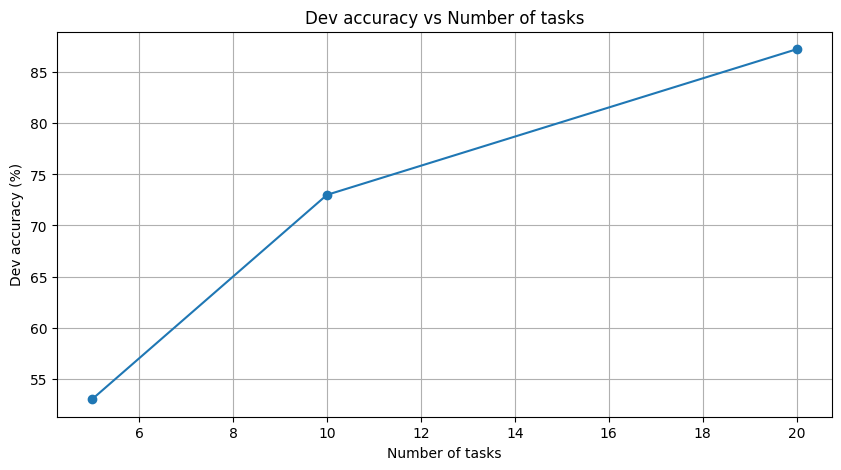

In [ ]:
# Plotting
import matplotlib.pyplot as plt

# Convert the dev_accs dictionary to lists of task numbers and accuracies
task_nums, accuracies = zip(*dev_accs.items())

plt.figure(figsize=(10, 5))
plt.plot(task_nums, accuracies, marker='o')
plt.xlabel('Number of tasks')
plt.ylabel('Dev accuracy (%)')
plt.title('Dev accuracy vs Number of tasks')
plt.grid(True)
plt.show()


### Testing the result

Since the testing data is sampled by TAs in advance, you should not change the code in `OmnigloTest` dataset, otherwise your score may not be correct on the Kaggle leaderboard.

However, fell free to chagne the variable `inner_train_step` to set the training steps on the query set images.

In [ ]:
import os

# test dataset
class OmniglotTest(Dataset):
    def __init__(self, test_dir):
        self.test_dir = test_dir
        self.n = 5

        self.transform = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, idx):
        support_files = [
            os.path.join(self.test_dir, "support", f"{idx:>04}", f"image_{i}.png")
            for i in range(self.n)
        ]
        query_files = [
            os.path.join(self.test_dir, "query", f"{idx:>04}", f"image_{i}.png")
            for i in range(self.n)
        ]

        support_imgs = torch.stack(
            [self.transform(Image.open(e)) for e in support_files]
        )
        query_imgs = torch.stack([self.transform(Image.open(e)) for e in query_files])

        return support_imgs, query_imgs

    def __len__(self):
        return len(os.listdir(os.path.join(self.test_dir, "support")))

In [ ]:
test_inner_train_step = 10 # you can change this

test_batches = 20
test_dataset = OmniglotTest("Omniglot-test")
test_loader = DataLoader(test_dataset, batch_size=test_batches, shuffle=False)

output = []
for _, batch in enumerate(tqdm(test_loader)):
    support_set, query_set = batch
    x = torch.cat([support_set, query_set], dim=1)
    x = x.to(device)

    labels = Solver(
        meta_model,
        optimizer,
        x,
        n_way,
        k_shot,
        q_query,
        loss_fn,
        inner_train_step=test_inner_train_step,
        train=False,
        return_labels=True,
    )

    output.extend(labels)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# write to csv
with open("output.csv", "w") as f:
    f.write(f"id,class\n")
    for i, label in enumerate(output):
        f.write(f"{i},{label}\n")

Download the `output.csv` and submit to Kaggle!

## **Reference**
1. Chelsea Finn, Pieter Abbeel, & Sergey Levine. (2017). [Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks.](https://arxiv.org/abs/1909.09157)
1. Aniruddh Raghu, Maithra Raghu, Samy Bengio, & Oriol Vinyals. (2020). [Rapid Learning or Feature Reuse? Towards Understanding the Effectiveness of MAML.](https://arxiv.org/abs/1909.09157)